In [1]:
using Flux, ParameterSchedulers, Optimisers, Statistics, CUDA 
using Base.Iterators: repeated, partition
using Printf, BSON, JLD2, LinearAlgebra
using ImageCore, Images
using MLDatasets: convert2image, CIFAR10
using Plots              
using StatsBase

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\oliwi\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


In [2]:
ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"

"true"

In [3]:
train_set = CIFAR10(:train)

dataset CIFAR10:
  metadata  =>    Dict{String, Any} with 2 entries
  split     =>    :train
  features  =>    32×32×3×50000 Array{Float32, 4}
  targets   =>    50000-element Vector{Int64}

In [7]:
feats = Float32.(train_set.features)
channel_means = [ mean(vec(feats[:,:,c,:])) for c in 1:3 ]
channel_stds  = [ std( vec(feats[:,:,c,:]) ) for c in 1:3 ]
@info "Computed channel means: $channel_means"
@info "Computed channel stds:   $channel_stds"

┌ Info: Computed channel means: Float32[0.49139968, 0.48215845, 0.4465309]
└ @ Main c:\Users\oliwi\Desktop\SGH\masgisterka\II_sem\Deep Learning\projekt_zaliczeniowy\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:4
┌ Info: Computed channel stds:   Float32[0.24703224, 0.24348514, 0.26158786]
└ @ Main c:\Users\oliwi\Desktop\SGH\masgisterka\II_sem\Deep Learning\projekt_zaliczeniowy\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:5


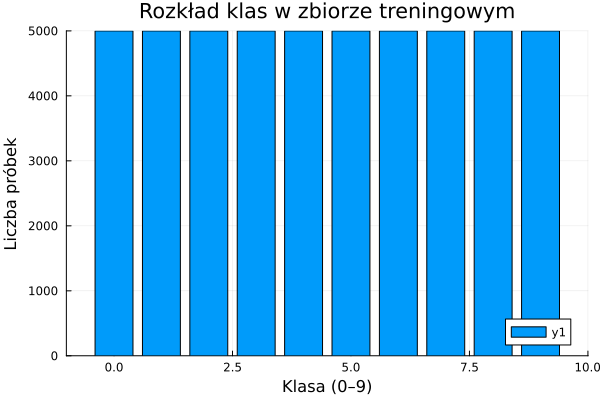

In [ ]:
cls_counts = countmap(train_set.targets)
bar(
    0:9,
    [get(cls_counts, i, 0) for i in 0:9],
    xlabel="Klasa (0–9)",
    ylabel="Liczba próbek",
    title="Rozkład klas w zbiorze treningowym",
)

In [16]:
using Images, ImageShow, Plots

# Jeżeli masz wektor nazw klas:
classes = ["plane","car","bird","cat","deer","dog","frog","horse","ship","truck"]

# Funkcja do siatki 3×3
function show_samples_grid(X, Y; n=9)
    idx = rand(1:size(X,4), n)
    plt = plot(layout = (3,3), margin=2Plots.mm, xticks=false, yticks=false)
    for (i,j) in enumerate(idx)
        raw = X[:,:,:,j] |> cpu
        chw = permutedims(raw, (3,1,2))
        img = collect(colorview(RGB, chw))
        # tutaj wstawiasz tytuł jako nazwę klasy:
        lab = isa(Y, AbstractMatrix) ? argmax(Y[:,j]) - 1 : Y[j]
        title = classes[lab+1]
        plot!(plt[i], img, seriestype = :heatmap,
              aspect_ratio=1, axis=false, title=title)
    end
    display(plt)
end


show_samples_grid (generic function with 1 method)

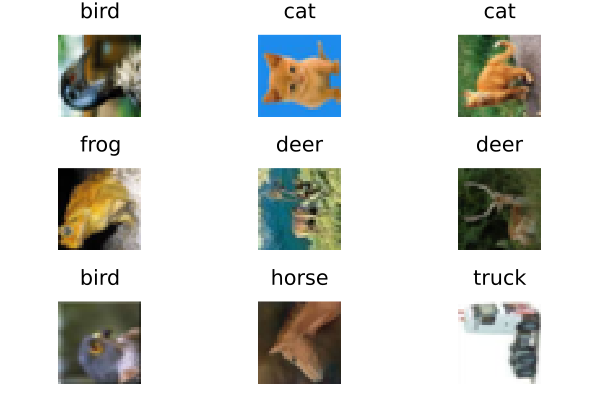

In [17]:
show_samples_grid(feats, train_set.targets; n=9)

In [18]:
use_cuda = true

true

In [19]:
if use_cuda && CUDA.functional()
    device = gpu
    @info "Training on GPU"
else
    device = cpu
    @info "Training on CPU"
end

┌ Info: Training on CPU
└ @ Main c:\Users\oliwi\Desktop\SGH\masgisterka\II_sem\Deep Learning\projekt_zaliczeniowy\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:6


In [20]:
epochs = 150;
batch_size = 64;

In [21]:
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, 32, 32, 3, length(idxs))
    for (i, idx) in enumerate(idxs)
        X_batch[:,:,:,i] = X[:,:,:,idx]
    end
    Y_batch = Flux.onehotbatch(Y[idxs], 0:9)
    return X_batch, Y_batch
end

make_minibatch (generic function with 1 method)

In [22]:
mb_idxs = partition(1:size(train_set.features, 4), batch_size)
train_set = [make_minibatch(train_set.features, train_set.targets, i) for i in mb_idxs] |> device

782-element Vector{Tuple{Array{Float32, 4}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}}:
 ([0.23137255 0.0627451 … 0.7058824 0.69411767; 0.16862746 0.0 … 0.6784314 0.65882355; … ; 0.59607846 0.46666667 … 0.38039216 0.5921569; 0.5803922 0.47843137 … 0.3254902 0.48235294;;; 0.24313726 0.078431375 … 0.54509807 0.5647059; 0.18039216 0.0 … 0.48235294 0.5058824; … ; 0.49019608 0.3254902 … 0.24313726 0.4627451; 0.4862745 0.34117648 … 0.20784314 0.36078432;;; 0.24705882 0.078431375 … 0.3764706 0.45490196; 0.1764706 0.0 … 0.16470589 0.36862746; … ; 0.4 0.19607843 … 0.13333334 0.32941177; 0.40392157 0.22352941 … 0.13333334 0.28235295;;;; 0.6039216 0.54901963 … 0.64705884 0.6392157; 0.49411765 0.5686275 … 0.6117647 0.61960787; … ; 0.34117648 0.3019608 … 0.48235294 0.56078434; 0.30980393 0.2784314 … 0.5137255 0.56078434;;; 0.69411767 0.627451 … 0.6039216 0.5803922; 0.5372549 0.6 … 0.59607846 0.5803922; … ; 0.3529412 0.3137255 … 0.44705883 0.5254902; 0.31764707 0.28627452 … 0.4745098 0.5215

In [23]:
test_set = CIFAR10(:test)
test_set = make_minibatch(test_set.features, test_set.targets, 1:size(test_set.features)[4]) |> device

(Float32[0.61960787 0.59607846 … 0.23921569 0.21176471; 0.62352943 0.5921569 … 0.19215687 0.21960784; … ; 0.49411765 0.49019608 … 0.11372549 0.13333334; 0.45490196 0.46666667 … 0.078431375 0.08235294;;; 0.4392157 0.4392157 … 0.45490196 0.41960785; 0.43529412 0.43137255 … 0.4 0.4117647; … ; 0.35686275 0.35686275 … 0.32156864 0.32941177; 0.33333334 0.34509805 … 0.2509804 0.2627451;;; 0.19215687 0.2 … 0.65882355 0.627451; 0.18431373 0.15686275 … 0.5803922 0.58431375; … ; 0.14117648 0.1254902 … 0.49411765 0.5058824; 0.12941177 0.13333334 … 0.41960785 0.43137255;;;; 0.92156863 0.93333334 … 0.32156864 0.33333334; 0.90588236 0.92156863 … 0.18039216 0.24313726; … ; 0.9137255 0.9254902 … 0.7254902 0.7058824; 0.9098039 0.92156863 … 0.73333335 0.7294118;;; 0.92156863 0.93333334 … 0.3764706 0.39607844; 0.90588236 0.92156863 … 0.22352941 0.29411766; … ; 0.9137255 0.9254902 … 0.78431374 0.7647059; 0.9098039 0.92156863 … 0.7921569 0.78431374;;; 0.92156863 0.93333334 … 0.32156864 0.3254902; 0.90588236

In [29]:
model = Chain(
    Conv((5,5), 3=>16, relu),
    MaxPool((2,2)),
    Conv((5,5), 16=>8, relu),
    MaxPool((2,2)),
    x -> reshape(x, :, size(x, 4)),
    Dense(200, 120),
    Dense(120, 84),
    Dense(84, 10),
    softmax
) |> device

Chain(
  Conv((5, 5), 3 => 16, relu),          # 1_216 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 16 => 8, relu),          # 3_208 parameters
  MaxPool((2, 2)),
  var"#29#30"(),
  Dense(200 => 120),                    # 24_120 parameters
  Dense(120 => 84),                     # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
  NNlib.softmax,
)                   # Total: 10 arrays, 39_558 parameters, 155.328 KiB.

In [30]:
model(train_set[1][1])

10×64 Matrix{Float32}:
 0.0941633  0.100524   0.117416   …  0.101236   0.0965508  0.100213
 0.0884494  0.0976842  0.0819656     0.0986104  0.10304    0.0910193
 0.0935055  0.0775246  0.098251      0.0856807  0.0871512  0.0928846
 0.143361   0.148603   0.127787      0.121174   0.117307   0.131587
 0.10286    0.106394   0.0995309     0.103908   0.0994873  0.0986669
 0.0794204  0.0704407  0.0819696  …  0.0740895  0.077868   0.0806973
 0.0964003  0.0896847  0.0923346     0.103527   0.105689   0.0984466
 0.105186   0.105492   0.0992483     0.108923   0.115961   0.102947
 0.077895   0.0770605  0.0760682     0.0804349  0.0916305  0.086358
 0.11876    0.126592   0.125428      0.122416   0.105315   0.11718

In [31]:
function loss(model, x, y, device = device)
    x = x |>cpu
    x_aug = x .+ 0.1f0*randn(eltype(x), size(x)) |> device
    y_hat = model(x_aug)
    return Flux.crossentropy(y_hat, y) 
end

loss (generic function with 2 methods)

In [32]:
loss(model, test_set[1],test_set[2])

2.3178692f0

In [33]:
accuracy(model,x, y) = mean(Flux.onecold(model(x)) .== Flux.onecold(y))

accuracy (generic function with 1 method)

In [34]:
accuracy(model,test_set[1],test_set[2])

0.1022

In [35]:
opt = Flux.Adam(0.001)
opt_state = Flux.setup(opt, model);
lr_schedule = ParameterSchedulers.Stateful(Exp(start = opt.eta/10, decay = 0.1))

ParameterSchedulers.Stateful{Exp{Float64}, Int64, ParameterSchedulers.var"#15#17"}(Exp{Float64}(0.0001, 0.1), 1, ParameterSchedulers.var"#15#17"())

In [ ]:
@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch = 1:epochs
    global best_acc, last_improvement
    Flux.train!(loss, model, train_set, opt_state)
    acc = accuracy(model,test_set[1],test_set[2])
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch, acc))
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to fashionMNIST_conv.bson")
        ps = cpu(Flux.state(model))
        BSON.@save "fashionMNIST_conv.bson" ps
        jldsave("fashionMNIST_conv.jld2"; ps)
        best_acc = acc
        last_improvement = epoch
    end
    if acc >= 0.95
        @info(" -> Early-exiting: We reached our target accuracy of 95%")
        break
    end
    if epoch - last_improvement >= 5 
        η = ParameterSchedulers.next!(lr_schedule) 
        if η ≥ 1e-10
            Optimisers.adjust(opt_state, eta = η)
            @warn(" -> Haven't improved in a while, dropping learning rate to $(η)!")
            last_improvement = epoch
        end
    end
    if epoch - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end